In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import halfnorm

In [36]:
data = torch.load('../../pre_calculated_logits/cifar10/resnet50_cross_entropy.pt')
# data = torch.load('../../pre_calculated_logits/cifar10_resnet110.pt')
# data = torch.load('../../pre_calculated_logits/cifar10_densenet121.pt')
# data = torch.load('../../pre_calculated_logits/cifar10_wide_resnet.pt')

# data = torch.load('../../pre_calculated_logits/cifar100/resnet50_cross_entropy.pt')
# data = torch.load('../../pre_calculated_logits/cifar100_densenet121.pt')
# data = torch.load('../../pre_calculated_logits/cifar100_wide_resnet.pt')
# data = torch.load('../../pre_calculated_logits/cifar100_resnet110.pt')

# data = torch.load('../../pre_calculated_logits/imagenet/resnet50_cross_entropy.pt')
data_fc = torch.load('../../pre_calculated_logits/imagenet/resnet50_cross_entropy_fc.pt') 
# data = torch.load('../../pre_calculated_logits/imagenet/vit_b_16_cross_entropy.pt')
# data_fc = torch.load('../../pre_calculated_logits/imagenet/vit_b_16_cross_entropy_fc.pt') 

load_features = data['features_val']
labels = data['labels_val']
logits = data['logits_val']
load_features.shape, labels.shape, logits.shape
load_features_fc = data_fc['features_val_fc']
labels_fc = data_fc['labels_val_fc']
logits_fc = data_fc['logits_val_fc']
load_features_fc.shape, labels_fc.shape, logits_fc.shape

# get wrongly prediction index with the confidence larger than 0.95
wrong_index = torch.where((labels != logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.8))[0]
# get correct prediction index with the confidence larger than 0.95
correct_index = torch.where((labels == logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.8))[0]
len(wrong_index), len(correct_index)

(196, 4740)

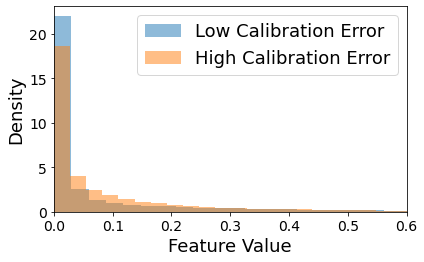

In [37]:
wrong_feature = load_features[wrong_index].flatten().cpu().numpy()
correct_feature = load_features[correct_index].flatten().cpu().numpy()
feature = load_features.flatten().cpu().numpy()
# select wrong feature with value larger than 0.01 and smaller than 1.5
wrong_feature_nozero = wrong_feature[(wrong_feature > 0.01) & (wrong_feature < 0.95)]
correct_feature_nozero = correct_feature[(correct_feature > 0.01) & (correct_feature < 0.95)]

# draw histogram for wrong_feature and correct_feature
plt.figure(figsize=(6, 2.5*1.5))
plt.hist(correct_feature, bins=100, alpha=0.5, label='Low Calibration Error', density=True)
plt.hist(wrong_feature, bins=100, alpha=0.5, label='High Calibration Error', density=True)
# y axis is density, x axis is feature value
plt.xlabel('Feature Value', fontsize=18)
# x limit to 1.0
plt.xlim(0, 0.6)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig('feature_distribution_pdf.pdf')
plt.show()

In [ ]:
# from scipy.stats import halfcauchy
# from scipy.stats import halfnorm

# x_range = (0.0, 1)

# features = load_features
# # plot the histogram of feature value of all units, except values largers than 0.4
# feature_index=np.random.choice(features.shape[1], 100)
# # feature_index=range(features.shape[1])


# plt.figure(figsize=(8,4))

# #plot the pdf as pdf
# wrong_hist = plt.hist(features[wrong_index][:,feature_index].flatten().cpu().numpy(), bins=100, range=x_range, alpha=0.5, label='Wrong', density=True)
# correct_hist= plt.hist(features[correct_index][:len(wrong_index)][:,feature_index].flatten().cpu().numpy(), bins=100, range=x_range, alpha=0.5, label='Correct', density=True)

# # plt.figure(figsize=(8,4))

# # #plot the pdf as pdf
# # wrong_hist = plt.hist(features[wrong_index].flatten().cpu().numpy(), bins=100, range=(0.0, 0.1), alpha=0.5, label='Wrong', density=True)
# # correct_hist= plt.hist(features[correct_index][:len(wrong_index)].flatten().cpu().numpy(), bins=100, range=(0.0, 0.1), alpha=0.5, label='Correct', density=True)


# # adding a fitted halfcauchy distribution curve
# x = np.linspace(x_range[0],x_range[1], 100)
# mean, std = halfcauchy.fit(features[wrong_index][:,feature_index].flatten().cpu().numpy())
# pdf = halfcauchy.pdf(x, loc=mean, scale=std)
# plt.plot(x, pdf, 'r-')
# print(std)

# mean, std = halfcauchy.fit(features[correct_index][:,feature_index].flatten().cpu().numpy())
# pdf = halfcauchy.pdf(x, loc=mean, scale=std)
# plt.plot(x, pdf, 'b-')
# print(std)
# # # adding a curve to fit the histogram, make it smooth
# # plt.plot(wrong_hist[1][1:], wrong_hist[0], 'r-')
# # plt.plot(correct_hist[1][1:], correct_hist[0], 'b-')


# plt.xlabel('Feature Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# calculate the mean entropy of wrong prediction before fc
entropy = -F.softmax(logits[wrong_index], dim=1) * F.log_softmax(logits[wrong_index], dim=1)
entropy = entropy.sum(dim=1)
print("wrong before fc: ",entropy.mean())

# calculate the mean entropy of correct prediction before fc
entropy = -F.softmax(logits[correct_index], dim=1) * F.log_softmax(logits[correct_index], dim=1)
entropy = entropy.sum(dim=1)
print("correct before fc: ",entropy.mean())

# calculate the mean entropy of wrong prediction after fc
entropy = -F.softmax(logits_fc[wrong_index], dim=1) * F.log_softmax(logits_fc[wrong_index], dim=1)
entropy = entropy.sum(dim=1)
print("wrong after fc: ",entropy.mean())

# calculate the mean entropy of correct prediction after fc
entropy = -F.softmax(logits_fc[correct_index], dim=1) * F.log_softmax(logits_fc[correct_index], dim=1)
entropy = entropy.sum(dim=1)
print("correct after fc: ",entropy.mean())

wrong before fc:  tensor(0.4127, device='cuda:0')
correct before fc:  tensor(0.1631, device='cuda:0')
wrong after fc:  tensor(0.6707, device='cuda:0')
correct after fc:  tensor(0.2683, device='cuda:0')


In [ ]:
torch.quantile(features[wrong_index],dim=0,q=0.99).mean()

tensor(2.1360, device='cuda:0')

165 4718


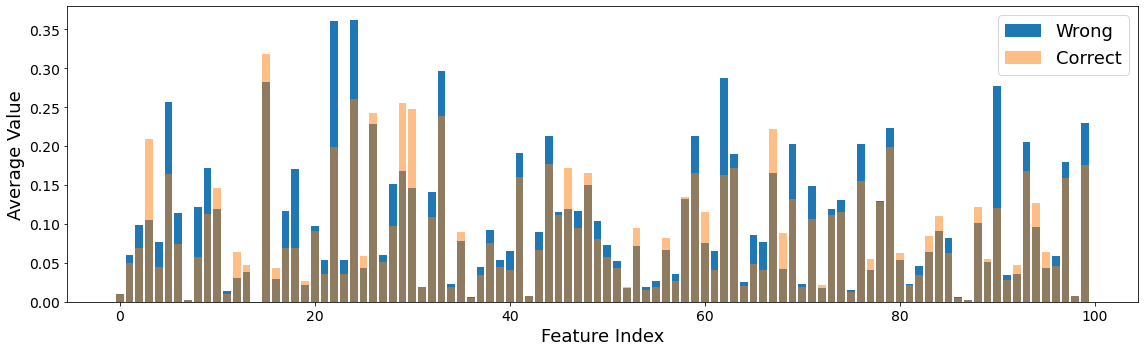

In [335]:
data = torch.load('../../pre_calculated_logits/cifar10/resnet50_cross_entropy.pt')

data_fc = torch.load('../../pre_calculated_logits/cifar10/resnet50_cross_entropy_fc.pt') 

load_features = data['features_val']
labels = data['labels_val']
logits = data['logits_val']
load_features.shape, labels.shape, logits.shape
load_features_fc = data_fc['features_val_fc']
labels_fc = data_fc['labels_val_fc']
logits_fc = data_fc['logits_val_fc']
load_features_fc.shape, labels_fc.shape, logits_fc.shape

# get wrongly prediction index with the confidence larger than 0.95
wrong_index = torch.where((labels != logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.95))[0]
# get correct prediction index with the confidence larger than 0.95
correct_index = torch.where((labels == logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.95))[0]
print(len(wrong_index), len(correct_index))


# randomly select 100 units from the feature
selected_units = np.random.choice(load_features.shape[1], 100, replace=True)
features = load_features[:,selected_units]
# plot all features of worngly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit
plt.figure(figsize=(16, 5))
plt.bar(np.arange(features.shape[1]), torch.mean(features[wrong_index],dim=0).cpu())
# plot all features of correctly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit in one figure
plt.bar(np.arange(features.shape[1]), torch.mean(features[correct_index],dim=0).cpu(), alpha=0.5)
plt.xlabel('Feature Index', fontsize=18)
plt.ylabel('Average Value', fontsize=18)
# larget font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title('Feature Distribution')
plt.legend(['Wrong', 'Correct'],fontsize=18)
plt.tight_layout()
plt.savefig('feature_distribution.pdf')
plt.show()

In [310]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = "feature_distribution.pdf"
image = Image.open(image_path)

# Display the image with larger text
plt.figure(figsize=(12, 6))
plt.imshow(image)
plt.axis('off')  # Hide the axes

# Add a title with larger font size
# plt.title('Histogram with Larger Text', fontsize=20)

# Show the plot
plt.show()

UnidentifiedImageError: cannot identify image file 'feature_distribution.pdf'

0 44


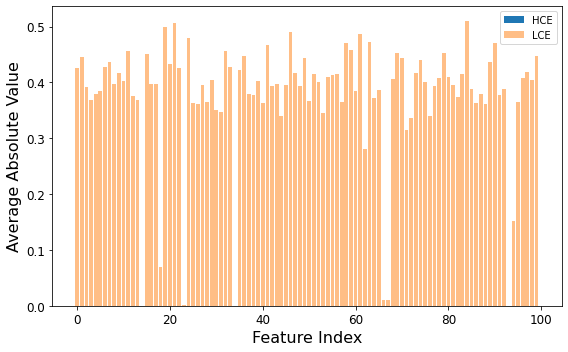

In [252]:
data = torch.load('../../pre_calculated_logits/imagenet/vit_l_16_cross_entropy.pt')
data_fc = torch.load('../../pre_calculated_logits/imagenet/vit_l_16_cross_entropy_fc.pt') 

load_features = data['features_val']
labels = data['labels_val']
logits = data['logits_val']
load_features.shape, labels.shape, logits.shape
load_features_fc = data_fc['features_val_fc']
labels_fc = data_fc['labels_val_fc']
logits_fc = data_fc['logits_val_fc']
load_features_fc.shape, labels_fc.shape, logits_fc.shape

# get wrongly prediction index with the confidence larger than 0.95
wrong_index = torch.where((labels != logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.95))[0]
# get correct prediction index with the confidence larger than 0.95
correct_index = torch.where((labels == logits.argmax(dim=1)) & (F.softmax(logits, dim=1).max(dim=1).values > 0.95))[0]
print(len(wrong_index), len(correct_index))


# randomly select 100 units from the feature
selected_units = np.random.choice(load_features.shape[1], 100, replace=True)
features = load_features[:,selected_units]
# plot all features of worngly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit
plt.figure(figsize=(8, 5))
plt.bar(np.arange(features.shape[1]), torch.mean(torch.abs(features[wrong_index]),dim=0).cpu())
# plot all features of correctly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit in one figure
plt.bar(np.arange(features.shape[1]), torch.mean(torch.abs(features[correct_index]),dim=0).cpu(), alpha=0.5)
plt.xlabel('Feature Index', fontsize=16)
plt.ylabel('Average Absolute Value', fontsize=16)
# larget font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Feature Distribution')
plt.legend(['HCE', 'LCE'])
plt.tight_layout()
plt.savefig('feature_distribution_vit.pdf')
plt.show()

#        conf  错  对
# resnet >0.8  471 5921
# resnet >0.9  271 5221
# resnet >0.95 161 4526
# resnet >0.99 53  3173
# _____________________
# ViT-B  >0.8  299 5973
# ViT-B  >0.9  39  1560
# ViT-B  >0.95 1   94
# ViT-B  >0.99 0   1
# _____________________
# ViT-L  >0.8  455 6431
# ViT-L  >0.9  92  3429
# ViT-L  >0.95 0   44
# ViT-L  >0.99 0   0

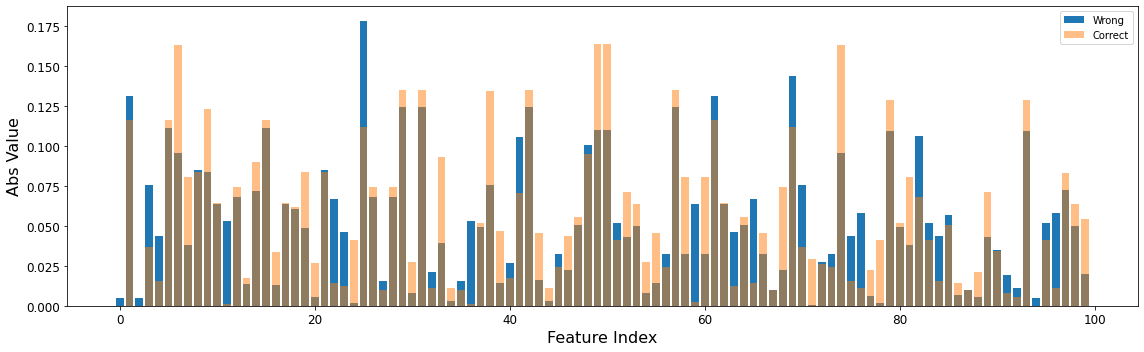

In [ ]:
# randomly select 100 units from the feature
selected_units = np.random.choice(features.shape[1], 100, replace=True)
features = load_features[:,selected_units]
# plot all features of worngly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit
plt.figure(figsize=(16, 5))
plt.bar(np.arange(features.shape[1]), torch.abs(features[wrong_index].mean(dim=0)).cpu())
# plot all features of correctly predicted samples using bar char, x-axis is each unit of features, y-axis is the average value of each unit in one figure
plt.bar(np.arange(features.shape[1]), torch.abs(features[correct_index].mean(dim=0)).cpu(), alpha=0.5)

plt.xlabel('Feature Index', fontsize=16)
plt.ylabel('Abs Value', fontsize=16)
# larget font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.title('Feature Distribution')
plt.legend(['Wrong', 'Correct'])
plt.tight_layout()
# plt.savefig('feature_distribution.pdf')
plt.show()